# Taller 4 - Representación y modelado

In [1]:
#
# herramientas básicas de Python; no entraremos en detalles de esto
#
import re
import os
import sys
#
# dibujo
#
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#
# pandas
#
#import pandas as pd
#
# sklearn
#
# import skimage.io as imgio # utilidades para cargar imágenes
import skimage as skim
from sklearn.model_selection import train_test_split

import numpy as np
import numpy.random as rng
import cv2 as cv

## Ejercicio 1 - Representaciones para clasificación de células

En los cuadernos de práctico 4-1 y 4-2 se discutió la importancia de elegir una representación adecuada para el problema a resolver, y cómo los resultados del aprendizaje pueden depender considerablemente de la representación usada.

En este ejercicio implementaremos un clasificador que indique el tipo de glóbulo blanco (GB) presente en una imagen de microscopía. Para ello utilizaremos 3 representaciones bien distintas y compararemos los resultados obtenidos con cada una:

1. Representación _a mano_ basada en conocimiento *a priori* del problema específico
1. Representación en base a características generales de la imagen
1. Representación mediante PCA. En este caso, los datos de cada imagen son  sus pixeles (dimensión enorme) y la idea es resumir la información de los pixeles en unas pocas componentes principales.


## Carga de los datos

Bajamos las imágenes y las etiquetas de internet.

In [2]:
!mkdir -p data
!wget -c --quiet  http://iie.fing.edu.uy/~nacho/data/globulos/globulos_blancos.zip
!unzip -q -o -d data globulos_blancos.zip
!wget -qO  etiquetas.csv http://iie.fing.edu.uy/~nacho/data/globulos/labels.csv

mapname:  conversion of  failed


Luego cargamos las imagenes y las etiquetas en variables, y hacemos un poco de limpieza, descartando aquellas imágenes sin etiqueta, o con más de un GB. También imprimimos el tamaño del array que contiene las imágenes.

In [3]:
#
# biblioteca nativa de Python para leer CSVs
#
import csv
#
# cargamos las imágenes
#
tipos = set(['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE'])

#
# cargamos las etiquetas
# descartamos las lineas sin etiqueta
# la info de las etiquetas es una tabla CSV (Comma Separated Values)
# de la forma:  ,numero de imagen, etiqueta(s) (la primera columna está vacía)
#
datos = list()
with open('etiquetas.csv') as csv_file:
  csv_reader = csv.reader(csv_file,delimiter=',',quotechar='"',skipinitialspace=True)
  next(csv_reader) # salteamos la primera fila, que es el encabezado
  for row in csv_reader: # para cada fila en el archivo
    num = int(row[1])
    eti = row[2].strip() # strip saca espacios a los costados
    fname = os.path.join("data",f"BloodImage_{num:05d}.jpg")
    if os.path.exists(fname) and eti in tipos:
      im = plt.imread(fname).astype(np.uint8)
      muestra = (num,im,eti)
      datos.append(muestra)
print("numero de muestras: ",len(datos))


numero de muestras:  347


## Inspección visual

Como siempre, lo primero que hacemos es mirar nuestros datos. Abajo mostramos imágenes ejemplo para cada tipo de GB en el set de datos.


EOSINOPHIL


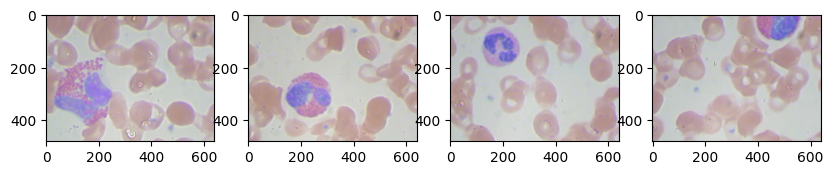

LYMPHOCYTE


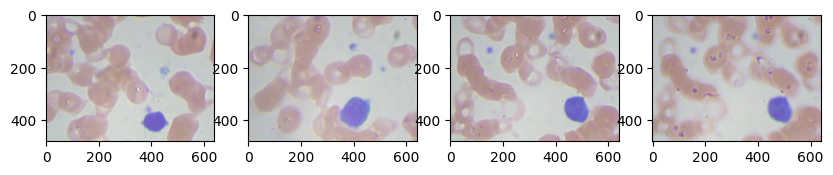

NEUTROPHIL


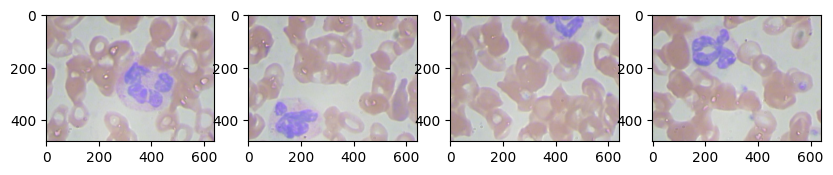

MONOCYTE


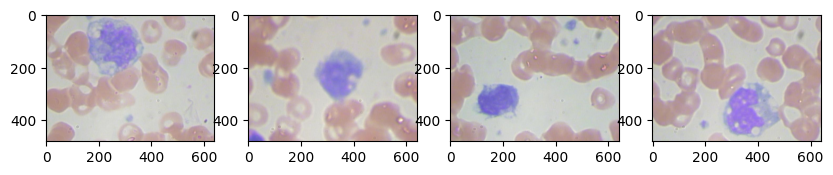

In [4]:
# Graficamos las imagenes, mostrando los 4 tipos de células
for t, tipo in enumerate(tipos):
  print(tipo)
  datos_tipo = [ d for d in datos if d[2] == tipo ]
  plt.figure(figsize=(10,40))
  for i in range(4): # 4 imagenes de cada tipo
    plt.subplot(1,4,i+1)
    plt.imshow(datos_tipo[i][1])
  plt.show()


### Análisis en base al color

Para obtener las imágenes de microscopía que vemos, las células de interés son teñidas con colorantes específicos (en este caso, rosado y azulado) que son absorbidos de distinta forma según el tipo de célula y sus organelos. Los glóbulos rojos, que no tienen nucleo, no absorben ningún colorante. Los glóbulos blancos, que sí contienen núcleo y ADN, absorben los colorantes y por eso se pueden distinguir. En particular, el ADN absorbe el colorante azul.

Las imágenes a color representan cáda color como una terna numérica (rojo, verde, azul); cada color es una combinación lineal de esos tres elementos. Por ejemplo, la terna (255,0,0) representa al rojo puro. La terna (255,255) (verde y verde) genera al amarillo.

Teniendo lo anterior en cuenta, es de esperarse que colores como el azulado y el rosado que observamos arriba puedan ser distinguidos inspeccionando los canales de color por separado. Por ejemplo, se podría esperar que los núcleos tengan una componente azulada importante.

Para poner a prueba lo anterior, veremos ahora las imágenes anteriores separadas por canal.




COLOR ROJO

TIPO EOSINOPHIL
--------------


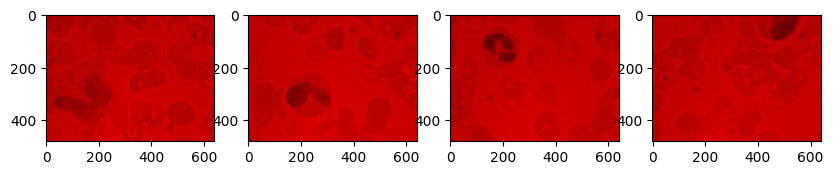

TIPO LYMPHOCYTE
--------------


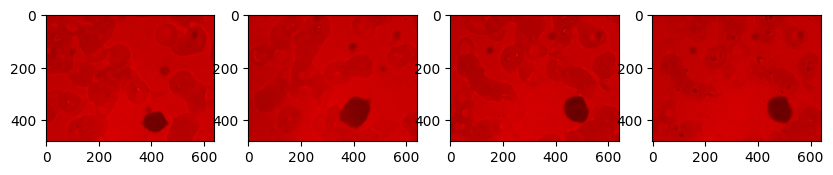

TIPO NEUTROPHIL
--------------


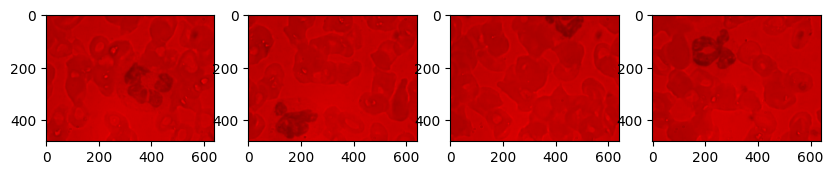

TIPO MONOCYTE
--------------


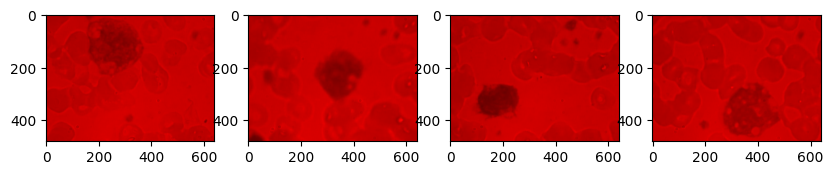



COLOR VERDE

TIPO EOSINOPHIL
--------------


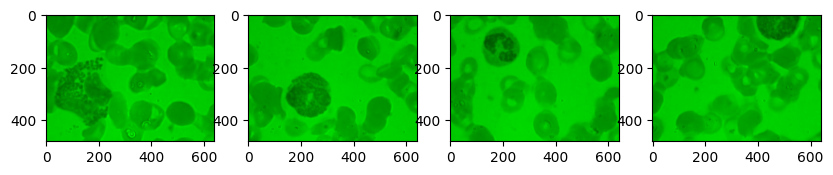

TIPO LYMPHOCYTE
--------------


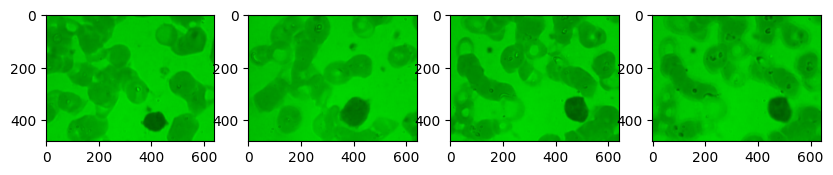

TIPO NEUTROPHIL
--------------


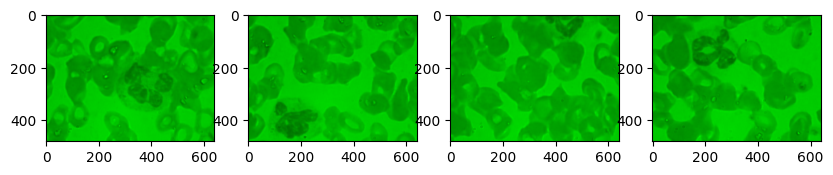

TIPO MONOCYTE
--------------


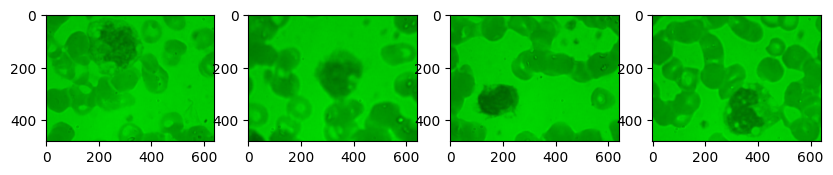



COLOR AZUL

TIPO EOSINOPHIL
--------------


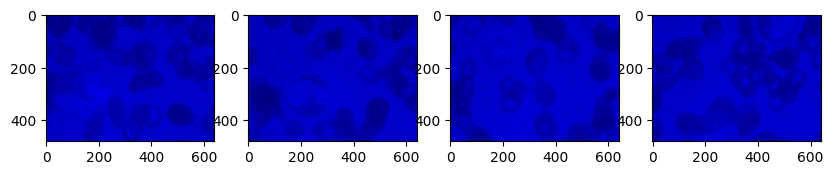

TIPO LYMPHOCYTE
--------------


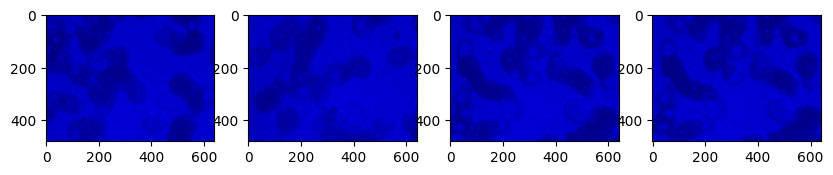

TIPO NEUTROPHIL
--------------


In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Graficamos las imagenes, mostrando los 4 tipos de células
colores=['ROJO','VERDE','AZUL']
for c,color in enumerate(colores):
  print(f"\n\nCOLOR {color}\n==============\n")
  for t, tipo in enumerate(tipos):
    print(f"TIPO {tipo}\n--------------")
    datos_tipo = [ d for d in datos if d[2] == tipo ]
    plt.figure(figsize=(10,40))
    for i in range(4): # 4 imagenes de cada tipo
      plt.subplot(1,4,i+1)
      im = np.copy(datos_tipo[i][1])
      # estas 3 lineas apagan los canales que no son 'c'
      canal = im[:,:,c]
      im = np.zeros(im.shape,dtype=np.uint8)
      im[:,:,c] = canal
      plt.imshow(im)
    plt.show()



### Preprocesamiento manual: transformación de colores

Antes que nada, aclaramos que el fondo presenta una fuerte componente en los tres canales. Esto se debe a que el blanco (o blancuzco, crema) se representa con la terna (255,255,255), es decir, es mezcla uniforme de los 3 canales.

Lo que sí se observa claramente es que los núcleos tienen baja intensidad en el rojo y alta intensidad en el azul. Podemos usar esa información para intentar distinguir los núcleos generando una nueva imagen (monocromática) restando el canal rojo al azul.

Abajo generamos un nuevo array de imagenes haciendo esta resta de colores, y mostramos las imagenes resultantes en escala de grises.

In [ ]:
datos_pre1 = list()

for i,d in enumerate(datos):
  # nota: la comparación ">" se aplica a cada elemento de im_original
  # esto produce una máscara del mismo tamaño que im_original
  num,im,eti = d
  imaux = 128 + im[:,:,2]/2 - im[:,:,0]/2
  datos_pre1.append((num,imaux,eti))

for t, tipo in enumerate(tipos):
  print(tipo)
  datos_tipo = [ d for d in datos_pre1 if d[2] == tipo ]
  plt.figure(figsize=(10,40))
  for i in range(4): # 4 imagenes de cada tipo
    plt.subplot(1,4,i+1)
    num,im,eti = datos_tipo[i]
    plt.imshow(im,cmap='gray')
  plt.show()



### Preprocesamiento: enmascarado

En las imágenes de arriba se ve que el núcleo de los GB es claramente identificable por su intesidad. Un último paso que podemos hacer, para deshacernos del ruido que introduce en el análisis el fondo de la imagen con células que no nos interesan, es aplicar un _umbral de intensidad_. Esto produce
una imagen en donde los valores por encima del umbral queden en 1 y los otros en 0, es decir, una imagen binaria donde los 1s marcan las zonas de interés (en inglés se usa la sigla ROI, por _Region of Interest_).

A este tipo de pseudoimagen se le suele llamar _máscara_, ya que ignoran (enmascaran) todo lo que no es relevante.




EOSINOPHIL


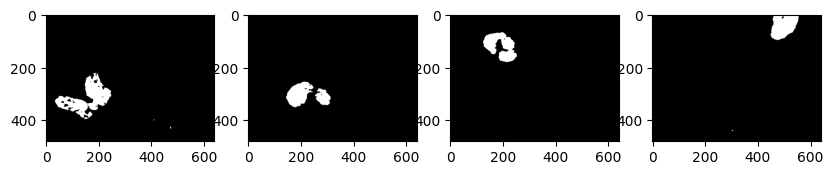

LYMPHOCYTE


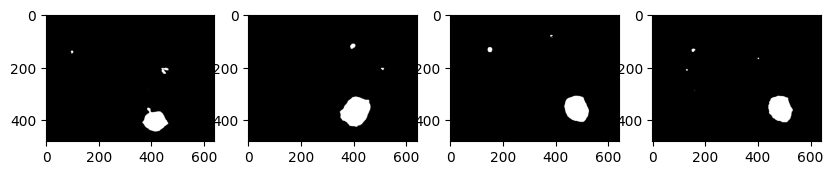

NEUTROPHIL


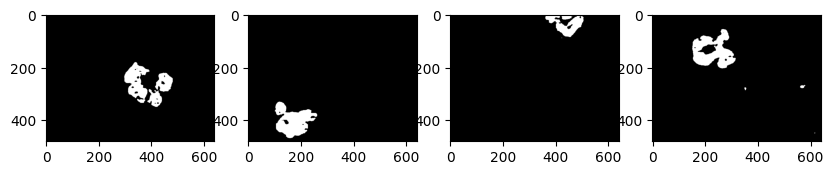

MONOCYTE


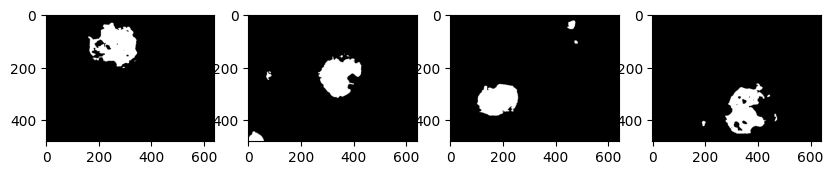

In [ ]:
from scipy import ndimage as ndi

datos_pre2 = list()
for i,d in enumerate(datos_pre1):
  # nota: la comparación ">" se aplica a cada elemento de im_original
  # esto produce una máscara del mismo tamaño que im_original
  num,im,eti = d
  im_umbral   = im > 150
  # reemplazamos dato i-esimo
  datos_pre2.append( (num,im_umbral,eti) )

#
# volvemos a mostrar
#
for t, tipo in enumerate(tipos):
  print(tipo)
  datos_tipo = [ d for d in datos_pre2 if d[2] == tipo ]
  plt.figure(figsize=(10,40))
  for i in range(4): # 4 imagenes de cada tipo
    plt.subplot(1,4,i+1)
    im = datos_tipo[i][1]
    plt.imshow(im,cmap='gray')
  plt.show()



### Refinamiento

Una cosa que suele suceder en estos casos es que la máscara no queda perfecta, sino que se cuelan pequeñas regiones a modo de ruido. Una forma de _refinar_ la máscara es eliminar esas regiones, sabiendo que las estructuras que buscamos no pueden ser menores que cierto tamaño.

Existe toda una rama del procesamiento de imágenes específica para operaro con imágenes binarias llamada _morfología matemática_; es algo bastante sencillo a pesar del nombre. La biblioteca `sklearn` tiene un paquete llamado `morphology` que implementa muchas utilidades de este tipo, en particular, la eliminación de _objetos_ (regiones) menores a cierto tamaño. Veamos esto en acción.


EOSINOPHIL


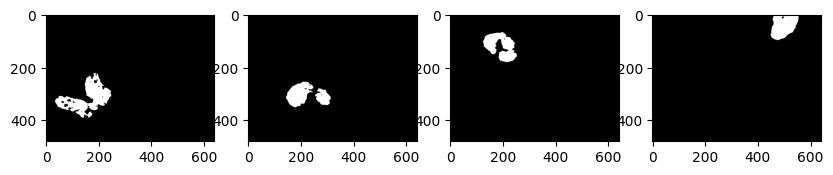

LYMPHOCYTE


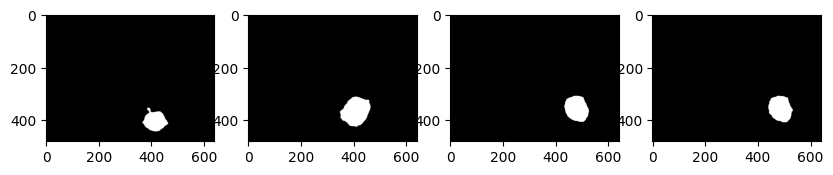

NEUTROPHIL


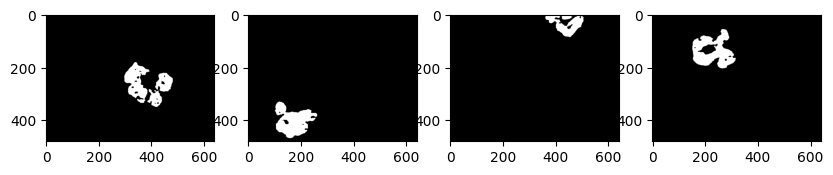

MONOCYTE


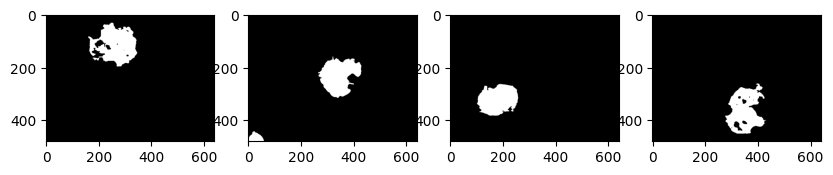

In [ ]:
from skimage import morphology as morph

datos_pre3 = list()
for i,d in enumerate(datos_pre2):
  num,im,eti = d
  im_clean = morph.remove_small_objects(im,1000)
  datos_pre3.append( (num,im_clean,eti) )

#
# volvemos a mostrar
#
for t, tipo in enumerate(tipos):
  print(tipo)
  datos_tipo = [ d for d in datos_pre3 if d[2] == tipo ]
  plt.figure(figsize=(10,40))
  for i in range(4): # 4 imagenes de cada tipo
    plt.subplot(1,4,i+1)
    im = datos_tipo[i][1]
    plt.imshow(im,cmap='gray')
  plt.show()


### Preprocesamiento: resumen

Luego del preprocesamiento, obtuvimos  imágenes que indican claramente el núcleo del GB. En este proceso  descartamos mucha información de las imagenes, pero nos quedamos con un tipo de información específica: los píxeles que pertenecen al núcleo de los GB.

**Ejercicio 1.1:** En el código de abajo dejamos una línea vacía para que usted calcule el **área del núcleo** en la imágen. Le sugerimos que lo haga sumando los píxeles de la imagen, que valen 1 si pertenecen al núcleo, y 0 en caso contrario. Puede usar la función `np.sum()`.

**Nota:** Note que las representaciones de arriba son aproximadamente **invariantes** a la rotación o el desplazmiento de la imagen (ej. estas transformaciones no afectan el área del núcleo).

EOSINOPHIL


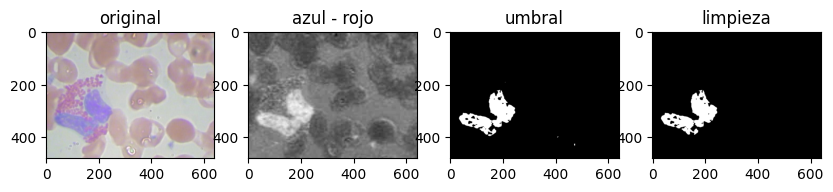

LYMPHOCYTE


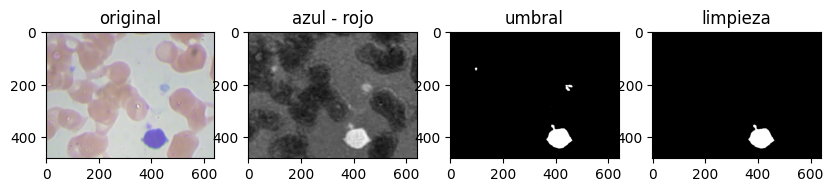

NEUTROPHIL


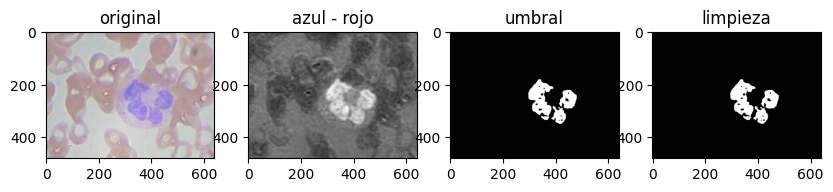

MONOCYTE


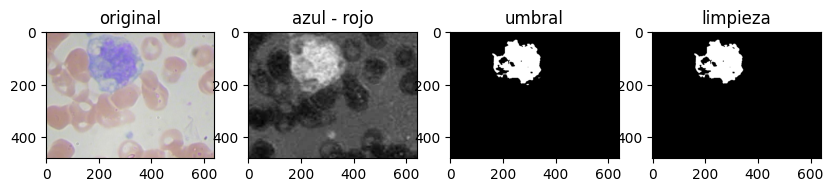

In [ ]:
#
# mostramos el proceso para la primera imagen de cada tipo
#
for t, tipo in enumerate(tipos):
  print(tipo)
  plt.figure(figsize=(10,40))
  im_tipo_orig = [ d[1] for d in datos      if d[2] == tipo ]
  im_tipo_pre1 = [ d[1] for d in datos_pre1 if d[2] == tipo ]
  im_tipo_pre2 = [ d[1] for d in datos_pre2 if d[2] == tipo ]
  im_tipo_pre3 = [ d[1] for d in datos_pre3 if d[2] == tipo ]
  plt.subplot(1,4,1)
  plt.imshow(im_tipo_orig[0])
  plt.title('original')
  plt.subplot(1,4,2)
  plt.imshow(im_tipo_pre1[0],cmap='gray')
  plt.title('azul - rojo')
  plt.subplot(1,4,3)
  plt.imshow(im_tipo_pre2[0],cmap='gray')
  plt.title('umbral')
  plt.subplot(1,4,4)
  plt.imshow(im_tipo_pre3[0],cmap='gray')
  plt.title('limpieza')
  plt.show()


### Representación manual

Se puede ver a simple vista en las imagenes que los diferentes tipos de GB tienen núcleos celulares con formas, estructuras y tamaños diferentes. De hecho, una de las principales formas de identificar visualmente los tipos de GB es según las características de su núcleo. Algunas características potencialmente útiles son su tamaño, ancho, altura, área, etc.

Además de esas características, hay otras más sofisticadas. En la [guía de histología](https://www.histology.leeds.ac.uk/blood/blood_wbc.php) se mencionan en particular la _cantidad de lóbulos_ y la _cantidad de agujeros_ que tiene el objeto. Los lóbulos son  estructuras circulares que pueden distinguirse en el objeto y que suelen aparecer _pegadas_. Los _agujeros_ son simplemente eso: la cantidad de agujeros que tiene el objeto en su interior.

Para construir nuestra primera representación del problema, usamos este conocimiento experto. En el bloque de código de abajo usamos nuevamente operaciones morfológicas de `skimage` para crear las siguientes características:

* número de lóbulos
* número de agujeros
* altura del objeto
* ancho del objeto
* área del objeto

Algunas de las operaciones morfológicas que usaremos no son triviales de explicar aquí. El lector interesado puede visitar la  [documentación del paquete skimage.morphology](https://scikit-image.org/docs/stable/api/skimage.morphology.html); no es difícil.

347
347
347
347


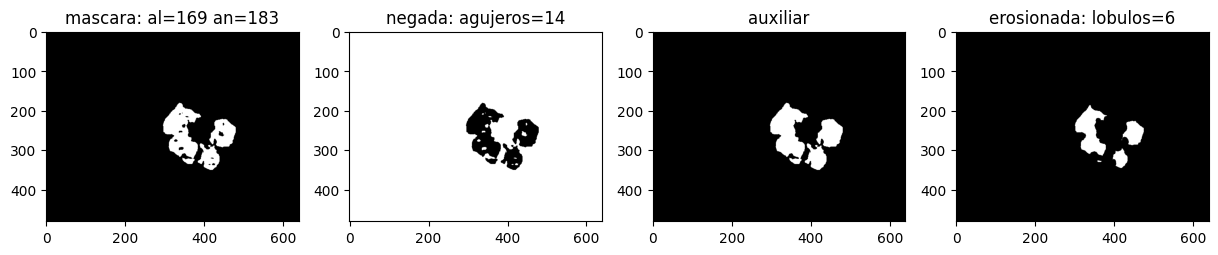

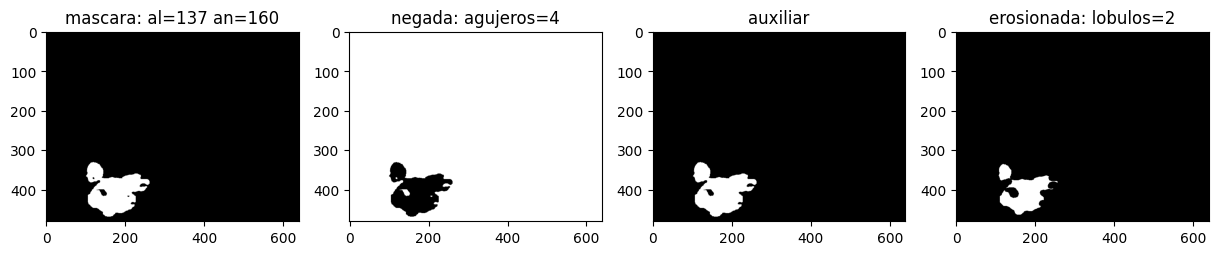

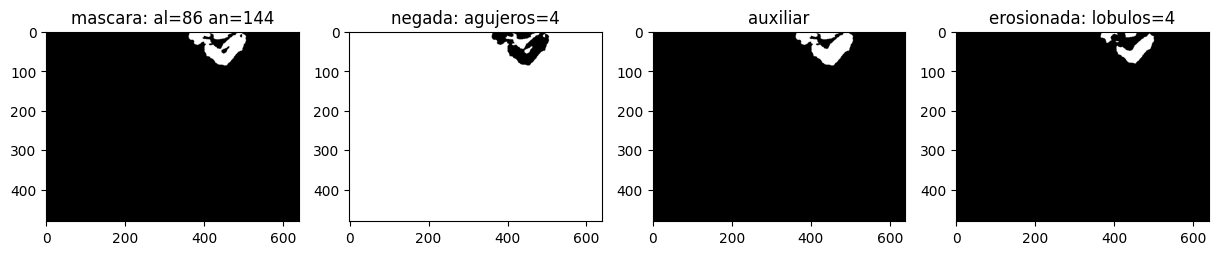

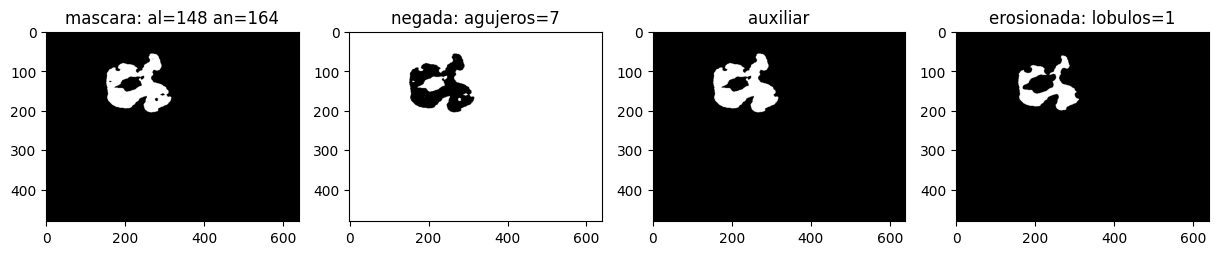

In [ ]:
import pandas as pd
#
# plantilla para la erosión
# ver https://scikit-image.org/docs/stable/api/skimage.morphology.html
# para detalles sobre la operación de erosión (binary_erosion)
#
plantilla = morph.disk(5)
#
# ahora vamos a crear una tabla de características y
# separar las etiquetas para luego construir un frame de Pandas
#
print(len(datos))
print(len(datos_pre1))
print(len(datos_pre2))
print(len(datos_pre3))
num_datos = len(datos_pre3)
X = np.empty((num_datos,5))
y = list() # np.empty(num_datos)
for i,d in enumerate(datos_pre3):
  num,im,eti = d
  #
  # primero las fáciles: alto, ancho y área
  # para las dos primeras analizamos las coordenadas mínima y máxima
  # vertical y horizontal de todos los puntos de la región.
  # las coordenadas las obtenemos con la función np.nonzero,
  # que nos devuelve dos listas: coordenadas horizontales y coordenadas verticales
  # de cada punto en la ROI. Ojo que las dimensiones en numpy son (fila,columna)
  # o sea (coord vertical, coord horizontal)
  #
  coord_v,coord_h = np.nonzero(im)
  # altura: diferencia entre máximo y mínimo de coord vertical
  alto  = np.max(coord_v)-np.min(coord_v)
  ancho = np.max(coord_h)-np.min(coord_h)
  area  = 0 # RELLENAR: cantidad de puntos blancos (=suma de pixeles)
  #
  # ahora las características sofisticadas:
  #
  # auxiliar: sacamos los agujeritos porque la erosión los puede agrandar
  # y separar cosas que deberían estar juntas
  im_aux = morph.remove_small_holes(im,area_threshold=200)
  # erosionamos para 'despegar' los lóbulos
  im_eroded = morph.binary_erosion(im_aux, plantilla)
  # contamos los lóbulos
  labels_ero,num_lob = morph.label(im_eroded,return_num=True)
  # contamos los agujeros: para esto etiquetamos la imagen inversa
  im_negated = ~im
  labels_neg,num_agu = morph.label(im_negated,return_num=True)
  # agregamos las características como dato adicional
  X[i,:] = [alto, ancho, area, num_lob, num_agu]
  y.append(eti)
  # mostramos las primeras 4 imagenes
  if i < 4:
    plt.figure(figsize=(15,40))
    plt.subplot(1,4,1)
    plt.imshow(im,cmap='gray')
    plt.title(f'mascara: al={alto} an={ancho}')
    plt.subplot(1,4,2)
    plt.imshow(im_negated,cmap='gray')
    plt.title(f'negada: agujeros={num_agu}')
    plt.subplot(1,4,3)
    plt.imshow(im_aux,cmap='gray')
    plt.title(f'auxiliar')
    plt.subplot(1,4,4)
    plt.imshow(im_eroded,cmap='gray')
    plt.title(f'erosionada: lobulos={num_lob}')
    plt.show()


nombre_cols = ['Alto', 'Ancho', 'Area','Lobulos', 'Agujeros']
# Juntamos los datos recolectados en un pandas dataframe
X_man = pd.DataFrame(X,columns=nombre_cols)

# dividimos los datos en entrenamiento y testeo
Xtrain_man, Xtest_man, ytrain_man, ytest_man = train_test_split(X_man, y, test_size=0.33, stratify=y, random_state=42)

# Estas 2 líneas son para resetear el índice de las filas. Es un detalle no importante
Xtrain_man.reset_index(inplace=True, drop=True)
Xtest_man.reset_index(inplace=True, drop=True)


### Características globales

Aunque en este problema particular hay algunas características útiles que podemos extraer de las imágenes de forma simple, este no siempre es el caso. Sin embargo, para algunos problemas comunes como la clasificación de imágenes, hay un repertorio de representaciones genéricas que suelen ser útiles.

Un ejemplo de esto es la representación mediante **local binary patterns** (LBP, [explicación aquí](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html)). En esta técnica, se analiza el patrón de vecinos alrededor de cada pixel de una imagen, y se le asigna a este grupo de píxeles un número que describe el patrón local de píxeles. Los detalles no importan mucho, pero estos diferentes patrones pueden representar por ejemplo líneas, bordes, áreas homogéneas, vértices, etc. Luego de que se asignó un patrón a cada pixel, contamos cuantas veces ocurre cada patrón, y lo ponemos en un vector.

Este vector representa, de cierta forma, la *textura* de la imagen. También **tiene cierta invarianza**, porque al sumar las ocurrencias de cada patrón, genera el mismo resultado ante traslaciones de la imagen. Según la forma en que se computen los LBP, estos pueden ser invariantes a rotación también (abajo usamos un método invariante a rotación).

En el bloque de código de abajo obtenemos la representación de LBP para cada imagen, donde cada columna indica la cantidad de veces que ocurre el LBP correspondiente. Luego lo separamos en set de testeo y entrenamiento, e imprimimos el set de entrenamiento.

In [ ]:
from skimage.feature import local_binary_pattern

radio = 3 # parámetro modificable
n_puntos = 8*radio #parámetro modificable
nbins = n_puntos+1 # número de patrones posibles
# generamos los nombres de las columnas
nombre_cols = ['LBP'+str(num+1) for num in range(nbins)]

# generamos un dataframe vacío para ir llenando con los datos

X = np.empty((num_datos,nbins))
for i,d in enumerate(datos_pre3):
  # calculamos el patrón LBP de cada pixel
  im = d[1]
  lbp = local_binary_pattern(im, P=n_puntos, R=radio, method='uniform')
  # extraemos la cantidad de ocurrencias de cada patrón
  histograma, bin_edges = np.histogram(lbp, bins=nbins)
  # agregamos el histograma de esta imagen como vector de características
  X[i,:] = histograma.tolist()

X_lbp = pd.DataFrame(X, columns=nombre_cols)

# separamos en train y test
Xtrain_lbp, Xtest_lbp, ytrain_lbp, ytest_lbp = train_test_split(X_lbp,y, test_size=0.33, stratify=y, random_state=42)

# Estas 2 líneas son para resetear el índice de las filas. Es un detalle no importante
Xtrain_lbp.reset_index(inplace=True, drop=True)
Xtest_lbp.reset_index(inplace=True, drop=True)
# Imprimimos los datos
print(Xtrain_lbp)
X=[]


     LBP1  LBP2  LBP3  LBP4  LBP5   LBP6   LBP7   LBP8   LBP9  LBP10  ...  \
0     2.0   5.0   3.0   7.0   3.0    8.0   17.0   50.0   42.0   76.0  ...   
1     1.0   1.0   6.0  23.0   0.0   57.0  104.0   95.0    0.0  127.0  ...   
2     1.0   3.0   3.0   7.0  21.0   43.0    0.0   89.0  234.0  157.0  ...   
3     3.0   4.0  17.0  51.0   0.0   78.0  189.0  166.0    0.0  209.0  ...   
4     2.0   0.0   4.0   7.0   5.0   14.0   43.0   86.0    0.0  183.0  ...   
..    ...   ...   ...   ...   ...    ...    ...    ...    ...    ...  ...   
227   1.0   1.0   2.0   7.0   0.0   30.0   56.0  120.0  121.0    0.0  ...   
228   1.0   6.0  27.0  52.0   0.0  110.0  215.0  204.0    0.0  226.0  ...   
229   2.0   2.0   6.0  14.0   0.0   37.0   69.0  142.0  139.0    0.0  ...   
230   1.0   6.0  32.0   0.0  50.0  136.0  148.0    0.0  123.0  147.0  ...   
231   4.0   8.0  10.0   4.0   9.0   13.0   20.0   42.0   90.0  106.0  ...   

     LBP16  LBP17  LBP18  LBP19  LBP20  LBP21  LBP22  LBP23     LBP24  LBP2

## Representación lineal, PCA

Finalmente, usamos otra representación de las imágenes, que obtenemos mediante PCA. Como ya vimos en clases pasadas, cuando aplicamos PCA a un conjunto de variables, la técnica nos devuelve las combinaciones lineales de estas variables que explican más variabilidad en los datos. En este caso aplicamos PCA directamente sobre los píxeles de las imágenes, entonces cada componente principal es una combinación lineal de píxeles. En otras palabras, cada componente principal es una suma ponderada de los píxeles de la imagen.

A diferencia de las dos representaciones anteriores, esta representación **no es invariante** a traslaciones y rotaciones.

En el bloque de código de abajo separamos el dataset en testeo y entrenamiento, les aplicamos PCA, y luego imprimimos los datos del set de entrenamiento.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_componentes = 25 # parametro modificable
nombres_cols = ['PC'+str(num+1) for num in range(num_componentes)]

# Alargamos las imagenes, para que quede una columna por cada pixel
num_pix = 640*480*3
num_datos = len(datos)
X_pix = np.empty((num_datos,num_pix))
for i,d in enumerate(datos):
  im = d[1]
  X_pix[i,:] = im.ravel()

# Separamos las imagenes alargadas en entrenamiento y testeo
X_train_pix, X_test_pix, ytrain_lin, ytest_lin = train_test_split(X_pix, y, test_size=0.33, stratify=y, random_state=42)

# Estandarizamos los datos
preproc = StandardScaler() # aquí generamos preproc que es una función para estandarizar datos
preproc.fit(X_train_pix) # aquí extraemos los parámetros de Xscore para estandarizar (media, sd)
X_train_pix = pd.DataFrame(preproc.transform(X_train_pix))
X_test_pix  = pd.DataFrame(preproc.transform(X_test_pix))

# Ajustamos un PCA a los datos de entrenamiento
modeloPCA = PCA(n_components=num_componentes)
modeloPCA.fit(X_train_pix)

# Obtenemos el valor de los PC para el entrenamiento y el testeo
Xtrain_lin = pd.DataFrame(modeloPCA.transform(X_train_pix))
Xtest_lin = pd.DataFrame(modeloPCA.transform(X_test_pix))

# Le ponemos nombre a las columnas
Xtrain_lin.columns = nombres_cols
Xtest_lin.columns = nombres_cols

Xtrain_lin.reset_index(inplace=True, drop=True)
Xtest_lin.reset_index(inplace=True, drop=True)

print(Xtrain_lin)


             PC1         PC2         PC3         PC4         PC5         PC6  \
0    1048.843264   31.784225  315.461674 -211.297424   94.241860   79.426214   
1     164.591656 -162.464459 -117.104756 -203.686386  416.943776  -35.361844   
2    -413.948407 -225.017185 -130.193501   97.079921  152.570956   68.970116   
3     106.932986  -17.517987  155.558083  283.980309  -45.180049 -167.791090   
4     178.469157  171.646219  244.920711  -55.791564  -99.471504  373.754950   
..           ...         ...         ...         ...         ...         ...   
227  -257.970127  107.945929 -165.369245  168.810481   65.168426  -84.741430   
228   -72.129860 -213.783380 -197.651856  -60.218610   59.073500  171.758932   
229   -55.693912 -229.048224   51.633910  132.295207  -85.651791   50.387454   
230  -116.299224  135.753515  134.967014 -339.384950 -293.004517 -198.427706   
231   228.672067  266.989257  135.473440  -12.578877  184.970670  -76.285114   

            PC7         PC8         PC9

## Clasificación

En este punto contamos con tres representaciones distintas de los datos:

* elegidas a mano en base a conocimiento experto (ancho, alto, etc.)
* utilizando características globales de la imagen (LBP)
* componentes principales de los pixeles

A continuación, utilizaremos cada una de las representaciones para ajustar un modelo de regresión logística regularizado que clasifique las imágenes.

 **Ejercicio 1.2:** Antes de correr el código que sigue, indique cuál piensa que será la mejor representación para clasificar y por qué.

*Puede insertar su respuesta aquí*

**Ejercicio 1.3:** En el siguiente bloque de código ajustamos la regresión logística y vemos el desempeño de cada representación. Se dejaron algunas líneas vacías para que usted complete.

In [ ]:
from sklearn.linear_model import RidgeClassifier

alpha = 1 # parametro modificable

# Estandarizamos los datos de representación manual previo al entrenamiento
scaler_man = StandardScaler()
Xtrain_man_norm = scaler_man.fit_transform(Xtrain_man)
Xtest_man_norm = scaler_man.transform(Xtest_man)

# Ajustamos y testeamos el modelo con la representacion manual
ridgeManual = RidgeClassifier(alpha=alpha)
ridgeManual.fit()                 # PARA RELLENAR
scoreManual = ridgeManual.score() # PARA RELLENAR

# Estandarizamos los datos de representación genérica previo al entrenamiento
scaler_lbp = StandardScaler()
Xtrain_lbp_norm = scaler_lbp.fit_transform(Xtrain_lbp)
Xtest_lbp_norm = scaler_lbp.transform(Xtest_lbp)

# Ajustamos y testeamos el modelo con la representacion generica
ridgeGenerica = RidgeClassifier(alpha=alpha)
ridgeGenerica.fit()                   # PARA RELLENAR
scoreGenerica = ridgeGenerica.score() # PARA RELLENAR

# Estandarizamos los datos de representación lineal previo al entrenamiento
scaler_lin = StandardScaler()
Xtrain_lin_norm = scaler_lbp.fit_transform(Xtrain_lin)
Xtest_lin_norm = scaler_lbp.transform(Xtest_lin)

# Ajustamos y testeamos el modelo con la representacion lineal
ridgeLineal = RidgeClassifier(alpha=alpha)
ridgeLineal.fit()                 # PARA RELLENAR
scoreLineal = ridgeLineal.score() # PARA RELLENAR

print(f"Rendimientos: representacion manual ({scoreManual*100:.1f}%), representacion generica ({scoreGenerica*100:.1f}%), representacion lineal ({scoreLineal*100:.1f}%)")


TypeError: ignored

**Ejercicio 1.4:** ¿Cómo se comparan los resultados con su hipótesis de arriba? Discuta brevemente las posibles discrepancias.

*Puede insertar su respuesta aquí*

**Ejercicio 1.5:** Aunque arriba comparamos las 3 representaciones distintas, a veces diferentes representaciones de un problema son complementarias y podemos mejorar el rendimiento mezclándolas. En el bloque de código de abajo combine un par de representaciones (o más) y mida el rendimiento del modelo resultante. Discuta sus resultados.

**Nota:** Lo que tiene que hacer es pegar dos dataframes, de forma que quede uno más grande con más columnas y la misma cantidad de filas. Se pone el ejemplo de cómo hacerlo para los datos de entrenamiento, pero debe replicarlo para los datos de testeo.

In [ ]:
# Unimos dos datasets de entrenamiento. Las filas están en el mismo orden, porque usamos
# el mismo seed para el train-test split para cada caso, asique sólo hay que pegar las columnas

# RELLENE: Ponga los datos que quiere concatenar en las listas de abajo
# recuerde que tenemos:
#  X_man: datos manuales
#  X_lbp: datos globales de la imagen
#  X_pca: componentes principales de los pixeles
#
lista_entrenamiento_concatenar = # Rellene
lista_testeo_concatenar = # Rellene

Xtrain_cat = pd.concat(lista_entrenamiento_concatenar, axis=1, join='inner', ignore_index=True)
Xtest_cat = pd.concat(lista_testeo_concatenar, axis=1, join='inner', ignore_index=True)

scaler_cat = StandardScaler()
Xtrain_cat_norm = scaler_lbp.fit_transform(Xtrain_cat)
Xtest_cat_norm = scaler_lbp.transform(Xtest_cat)

ridgeCat = RidgeClassifier(alpha=1)
ridgeCat.fit(X=Xtrain_cat_norm, y=ytrain_lin)
scoreCat = ridgeCat.score(Xtest_cat_norm, ytest_lin)

print(f"El rendimiento del modelo que eligió es {scoreCat*100:.1f}%")

*Introduzca su respuesta aquí*

**Ejercicio 1.6:** En el análisis hasta ahora, usamos más de un hiperparámetro en diferentes pasos. Por ejemplo, la distancia y la cantidad de vecinos en el LBP, la cantidad de componentes en el PCA, y el valor del término de regularización (alpha) en el modelo de Ridge. ¿Piensa que pueden cambiar los resultados cambiando estos parámetros? Ponga a prueba y discuta

*Inserte su respuesta aquí*

**Extra 1.1:** En todo lo realizado anteriormente, comparamos las diferentes representaciones usando un clasificador lineal con regularización Ridge. ¿Piensa que pueden cambiar los resultados si usamos otro tipo de clasificador? Ponga a prueba entrenando otro clasificador (por ejemplo, árbol de decisión o K vecinos más cercanos) con las diferentes representaciones. Discuta sus resultados.

**Nota:** Si usa KNN recuerde normalizar las variables. Para el árbol de decisión no es necesario. Vea que para la regresión lineal activamos la opción *normalize=True*, que no está disponible en KNeighborsClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#
# comienzo de código: ejercicio Extra 1.1
#

#
# fin de código
#

## Ejercicio 2 - Análisis de texto para clasificar opiniones de películas

Las imágenes, como las que vimos en el ejercicio anterior, son un tipo de dato muy analizado en aprendizaje automático. Otro de los principales tipos de datos analizados es el lenguaje natural, o el texto escrito. En este ejercicio veremos una de las representaciones más básicas para trabajar con texto, la representación de **bag-of-words**.

Utilizaremos una base de datos que tiene miles de críticas de películas extraídos de IMDB, cada uno clasificado como crítica positiva o negativa. Los datos son extraídos de [este link](http://ai.stanford.edu/~amaas/data/sentiment/), y el análisis es casi el mismo que está presentado en el capítulo 7 del Muller \& Guido.


Comenzamos importando los datos de internet y descomprimiéndolos.

In [ ]:
!mkdir -p data_texto
!wget -c https://www.dropbox.com/s/bt2rbdjxesfnry1/aclImdb.zip
!unzip -o -d data_texto aclImdb.zip

**Nota al margen:** Los datos importados están en un conjunto de carpetas ordenadas, que puede ver en la carpeta *data_texto* a la izquierda. Hay una carpeta con los datos de entrenamiento y otra con los datos de testeo. Cada carpeta además tiene una carpeta con las críticas positivas y otra con las negativas. Cada crítica es un archivo de texto. Cargar estos datos podría ser engorroso si lo tenemos que hacer a mano, pero el sklearn tiene una función que carga de forma ordenada todos los datos, y usa los nombres de las carpetas como etiquetas.

Abajo cargamos los datos de entrenamiento, y los ponemos en una lista que contiene el texto de cada crítica (*text_train*) y en una lista que contiene las etiquetas indicando si la crítica es positiva o negativa (*y_train*).

Luego imprimimos el primer elemento de la lista *text_train*.

In [ ]:
from sklearn.datasets import load_files

reviews_train = load_files("data_texto/aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("Clase de variable que es text_train: {}".format(type(text_train)))
print("Cantidad de documentos en text_train: {}".format(len(text_train)))
print("Documentos por clase (train): {}".format(np.bincount(y_train)))
print("Segundo documento en text_train:\n{}".format(text_train[1]))

**Ejercicio 2.1:** ¿Es la crítica impresa arriba positiva o negativa? Intente describir qué características de la misma piensa que podría usar un algoritmo para clasificarla. En lo posible, responda este ejercicio antes de seguir avanzando.

*Inserte su respuesta aquí*

A continuación importamos también los datos de testeo, y eliminamos algunos caracteres de formateo que pueden tener los datos.

In [ ]:
reviews_test = load_files("data_texto/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Cantidad de documentos en set de testeo: {}".format(len(text_test)))
print("Documentos por clase (test): {}".format(np.bincount(y_test)))

# eliminamos algunos caracteres de formateo
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Ahora con los datos cargados, los convertiremos a una representación con la que es más fácil trabajar, la representación de **bag-of-words**. En esta representación, lo que tenemos es simplemente una indicación de qué palabras tenemos en el texto, y cuantas veces ocurre cada una. La representación se llama bag-of-words porque sólo nos quedamos con esa lista de palabras, y perdemos toda la demás estructura del texto (ej. las relaciones gramáticas entre las palabras, su orden en el texto, etc).

Lo primero que se hace para armar la representación es tomar cada secuencia de caracteres que tenemos y separarla en palabras (*tokenizar*).

Luego, nos fijamos en nuestros datos todas las palabras que tenemos, y con eso construimos un *diccionario* o *vocabulario* de las palabras posibles para nuestros datos. Este vocabulario tendrá un determinado orden, y cada palabra tiene su índice que la caracteriza.

Finalmente, para cada documento (que ahora es una lista de palabras) armamos un vector con el mismo largo que nuestro diccionario, donde cada entrada del vector indica con un número cuantas veces ocurre la palabra correspondiente a ese índice. De esa forma, cada archivo de texto lo representamos como un vector que indica cuantas veces ocurre cada palabra del diccionario, sin mantener las relaciones entre las mismas, lo que es la representación **bag-of-words**.

El proceso descrito arriba se ilustra en la imagen de abajo (Figura 7-1 del Muller \& Guido).



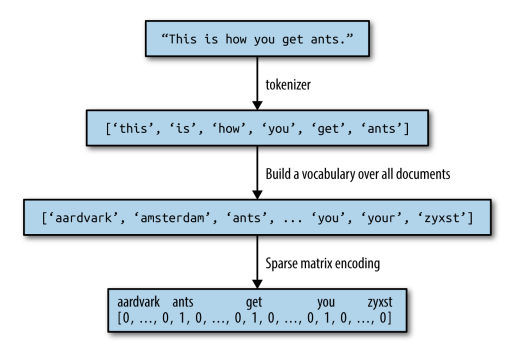

El paquete sklearn cuenta con una función llamada *CountVectorizer* que recibe una lista de documentos de texto y arma el diccionaro con las mismas. Luego podemos usar el diccionario creado para transformar listas de documentos a la representación bag-of-words.

En el bloque de código de abajo utilizamos CountVectorizer para convertir las críticas de películas al formato bag-of-words.

**Ejercicio 2.2:** Note el parámetro min_df=5 en el llamado a CountVectorizer. Este parámetro hace que en el diccionario generado sólo se incluyan palabras que aparecen en al menos 5 documentos en la base de datos. ¿Porqué cree que puede ser deseable eliminar las palabras que aparecen en menos de 5 documentos? (esto se discute en el libro, puede buscar allí, o especular)

*Inserte su respuesta aquí*

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

A continuación imprimimos los primeros 1000 elementos del vector que representa al primer documento de texto. Como el mismo está guardado en formato *sparse matrix*, esto sólo nos devuelve un indicador de cuales elementos son distintos de 0.

In [ ]:
print("X_train with min_df: {}".format(repr(X_train)))
print(X_train[0,0:1000])

**Ejercicio 2.3:** En el bloque de código anterior se ve que de los primeros mil elementos del vector del primer documento de texto, sólo 3 son diferentes que 0. ¿Qué significa esto, en términos de las palabras del documento y del diccionario que armamos?

*Inserte su respuesta aquí*

Para ilustrar, abajo extraemos las palabras del diccionario que generamos, con la función *get_feature_names*. Luego, imprimimos algunas de las palabras del diccionario

In [ ]:
nombres_palabras = vect.get_feature_names_out()
print("Primeras 20 entradas del diccionario:\n{}".format(nombres_palabras[:20]))
print("Entradas 20010 a 20030 del diccionario:\n{}".format(nombres_palabras[20010:20030]))
print("Entradas 1, 1001, 2001, etc:\n{}".format(nombres_palabras[::1000]))

Finalmente, usamos la representación bag-of-words de las críticas para entrenar un clasificador que determine si una crítica es positiva o negativa.

In [ ]:
from sklearn.linear_model import LogisticRegression

clasificador_opinion = LogisticRegression(max_iter=1000)
clasificador_opinion.fit(X_train, y_train)
rendimiento = clasificador_opinion.score(X_test, y_test)

print(f"El rendimiento en el set de testeo es {rendimiento*100}%")

**Extra 2.1:** Note que el modelo demora un tiempo en entrenarse. Esto es en parte por la gran cantidad de variables que tenemos (el diccionario tiene muchos miles de palabras). ¿De qué forma se le ocurre que podríamos reducir la cantidad de palabras en el diccionario para reducir el tiempo de entrenamiento, sin comprometer mucho el rendimiento? (pista: una forma involucra una de las herramientas que mencionamos más arriba, y otra manera está mencionada en el capítulo 7 del libro)

**Extra 2.2:** En el capítulo 7 hay una sección (página 341) que habla de una variante del método que usa más de una palabra, en lugar de palabras aisladas (n-Grams). Explique brevemente en qué consiste este método de los n-Grams, qué ventajas pueden tener con respecto a sólo usar las palabras aisladas, y qué dificultad puede haber en usar combinaciones de muchas palabras.